In [ ]:
%matplotlib inline

In [1]:
import os
import mne
import numpy as np


# Preprocessing
The steps in EEG preprocessing:

* Highpass filter
* Lowpass filter
* Artefact rejection
    * Ocular artifacts (EOG)
    * Heartbeat artifacts (ECG)
    * Power line noise
    * Methods:
        * Thresholding
        * ICA
* (Rereference)
* Epoching
* Evokeds (i.e. averaging)


In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████| Downloading : 1.54G/1.54G [01:03<00:00,    26.1MB/s]

Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.


Decompressing the archive: /Users/jakobgrohn/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/Users/jakobgrohn/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/Users/jakobgrohn/.mne/mne-python.json


In [68]:
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

Opening raw data file /Users/jakobgrohn/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [69]:
raw.pick_types(meg=False, eeg=True, stim=True)

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~2.9 MB, data not loaded>

Default filtering for the sample data is:
* highpass: 0.1 Hz
* lowpass: 40 Hz

You can see this by:
print(raw.info)

In [70]:
# Filtering data

raw_highpass = raw.load_data().copy().filter(l_freq=0.2, h_freq=None)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Filter length: 2479 samples (16.510 sec)



In [71]:
# Low pass
raw_lowpass = raw.load_data().copy().filter(l_freq=None, h_freq=70)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 5.08 Hz (-6 dB cutoff frequency: 72.54 Hz)
- Filter length: 99 samples (0.659 sec)



Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.0s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


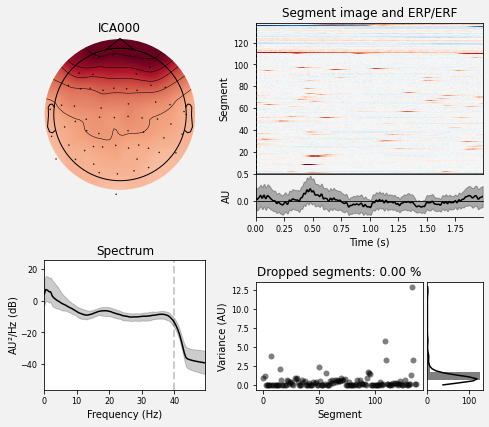

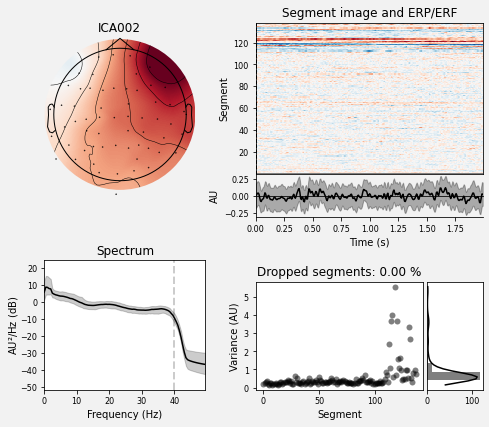

In [72]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)
ica.exclude = [0, 2]  # details on how we picked these are omitted here
ica.plot_properties(raw, picks=ica.exclude);

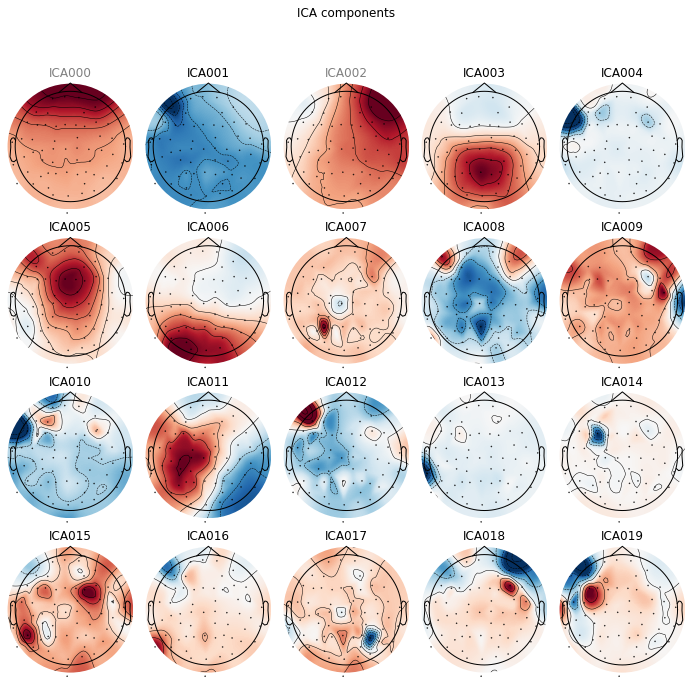

In [73]:
ica.plot_components();
# Removing component number 0 and 2 from data (repsectively represents eyeblinks and saccades )

Creating RawArray with float64 data, n_channels=20, n_times=41700
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


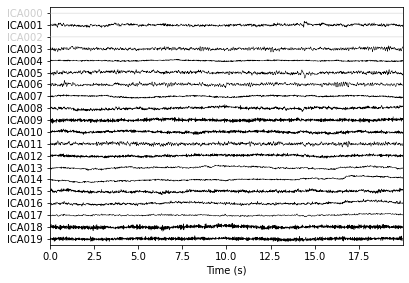

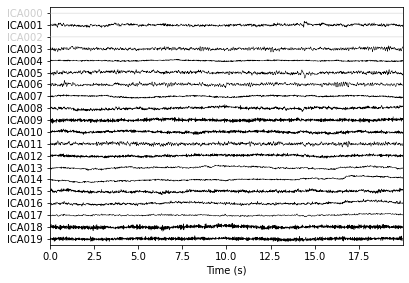

In [62]:
#Plotting the time series of the ICA.
ica.plot_sources(raw, show_scrollbars=False) # Don't know how to interpret this..


In [22]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components


<Raw | sample_audvis_filt-0-40_raw.fif, 68 x 41700 (277.7 s), ~24.6 MB, data loaded>

There are many options with ICA, see
https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
for a tutorial on ICA in MNE-python.

In [13]:
# the stimulus channel on the Electra vector view is: STI 014
events = mne.find_events(raw, stim_channel='STI 014')

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [14]:
events = mne.find_events(raw)

319 events found
Event IDs: [ 1  2  3  4  5 32]


In [16]:
event_dict = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              }

In [18]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']


In [19]:
reject = dict(eeg=150e-6) # 150 µV
picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)

epochs = mne.Epochs(raw, events, event_dict, -.2, 0.5, picks=picks,
                    baseline=None, reject=reject, preload=True)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 288 events and 106 original time points ...
0 bad epochs dropped


# Comparing evokeds

To visually comparing different evoked objects it is a good idea to calculate
 a _difference  wave_, i.e. one condition minus the other condition. In
 MNE-python ```mne.combine_evokeds```can do that.

In [51]:
# Extracting the auditory and visual trials
epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place

aud_left_epochs = epochs['auditory/left']
vis_left_epochs = epochs['visual/left']
aud_right_epochs = epochs['auditory/right']
vis_right_epochs = epochs['visual/right']


aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']

Dropped 0 epochs: 


In [52]:
# Averaging across all trials
aud_left_evoked = aud_left_epochs.average()
vis_left_evoked = vis_left_epochs.average()

aud_right_evoked = aud_right_epochs.average()
vis_right_evoked = vis_right_epochs.average()

aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

In [59]:
# Change to your evokeds
difference_wave = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])

combining channels using "gfp"


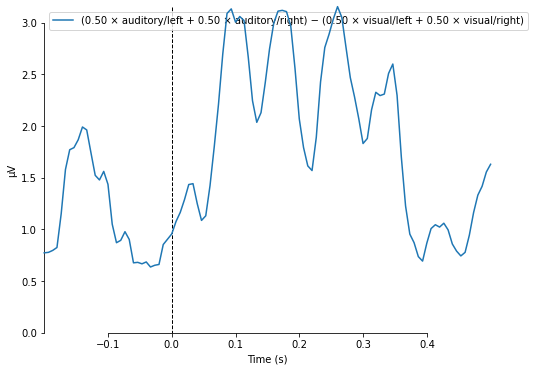

[<Figure size 576x432 with 1 Axes>]

In [60]:
# Plotting difference wave
mne.viz.plot_compare_evokeds(difference_wave)

See also:
https://mne.tools/stable/generated/mne.viz.plot_compare_evokeds.html

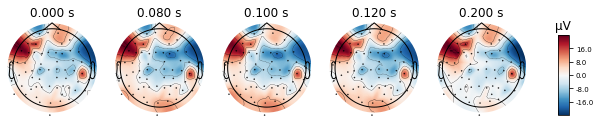

Figure(648x158.4)


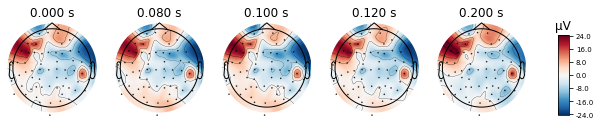

Figure(648x158.4)


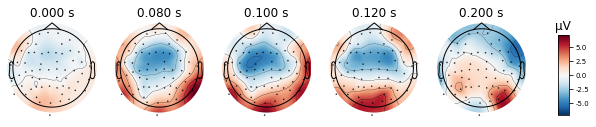

Figure(648x158.4)


In [61]:
# Plotting both evoked conditions '
print(aud_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2]))
print(vis_evoked.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2]))
print(difference_wave.plot_topomap(times=[0., 0.08, 0.1, 0.12, 0.2]))